**Project Network Analysis**

Step 3.1: Bipartite Graph (Node Embedding + Most Similar to Sanctioned Suppliers)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Required packages
!pip install fuzzywuzzy  &> /dev/null
!pip install Node2Vec &> /dev/null

In [ ]:
from networkx.algorithms.isolate import isolates
import pandas as pd
import networkx as nx
from networkx.algorithms import bipartite
import os
import matplotlib.pyplot as plt
from fuzzywuzzy import fuzz
import numpy as np
import matplotlib as mlt
from node2vec import Node2Vec

/usr/local/lib/python3.7/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [ ]:
path = '/content/drive/MyDrive/3. IU Courses/Courses/5. Network Analysis/Project/Final/data'
output_path = '/content/drive/MyDrive/3. IU Courses/Courses/5. Network Analysis/Project/Final/output'

# Reading Procurement Data
wb_data = pd.read_excel(os.path.join(output_path, "WB_table.xlsx"))
sanctioned_data = pd.read_excel(os.path.join(path, "Sanctioned_List.xlsx"))

In [ ]:
wb_data.head()

,Fiscal Year,Borrower Country,Supplier,Total Contract Amount (USD)
0,2022,Serbia,ASSECO SEE D.O.O.,3333598
1,2022,Ethiopia,"EPTISA SERVICIOS DE INGENIERIA, S.L. IN ASSOCI...",1851919
2,2022,China,"SHENZHEN CITY DONGSHEN ENGINEERING CO., LTD",14986361
3,2022,Turkey,KOLTEK MUSAVIRLIK A.S.,777600
4,2022,Chad,UNICEF,19326986


**Node2Vec To Find Most Similar Firms Which Are Sanctioned**

<font color = 'grey'>***Node embedding for each year***

Computing transition probabilities:   0%|          | 0/6844 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 1/1 [00:04<00:00,  4.08s/it]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).


Computing transition probabilities:   0%|          | 0/6180 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 1/1 [00:03<00:00,  3.40s/it]


Computing transition probabilities:   0%|          | 0/2973 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 1/1 [00:01<00:00,  1.48s/it]


Computing transition probabilities:   0%|          | 0/1664 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]


Computing transition probabilities:   0%|          | 0/1677 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


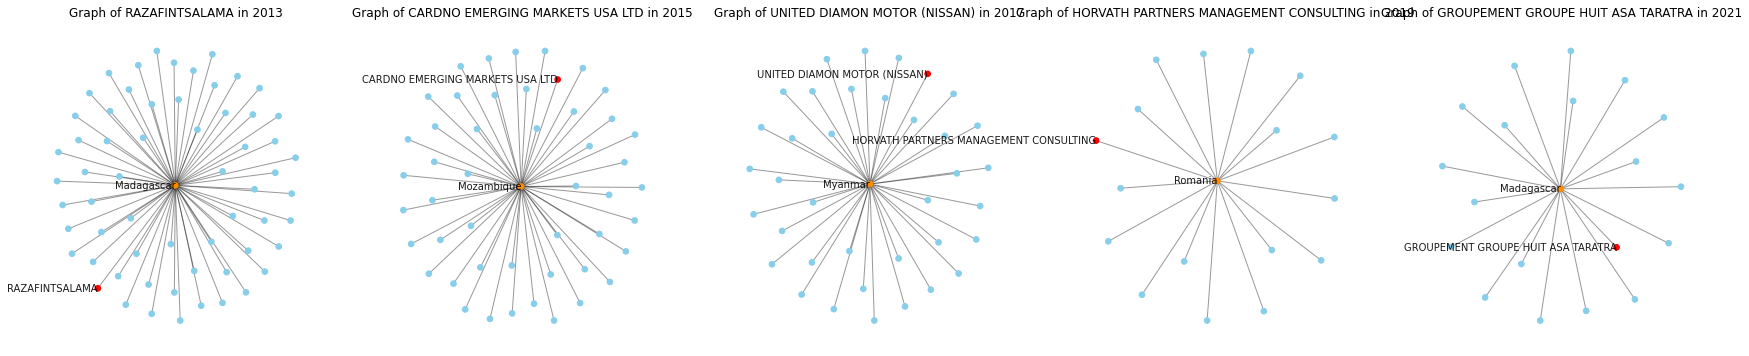

In [ ]:
# Doing the anlaysis by year (bipartite)
node_list = ['TRACTEBEL ENGINEERING S.A.']

history = [2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]

#fig = plt.figure("Degree of a Network Science graph", figsize=(12, 6))
# Create a gridspec for adding subplots of different sizes

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(30,6))

ax = axes.flatten()
i = 0
for year in history:
  wb_data_filter = wb_data[wb_data['Fiscal Year']==year]
  # Grouping repeated transactions between country and suppliers
  wb_data_group = wb_data_filter.groupby(['Fiscal Year','Borrower Country','Supplier'])['Total Contract Amount (USD)'].sum() 
  wb_data_group = wb_data_group.reset_index()
  # Setting up the network 
  G = nx.Graph()
  G.add_nodes_from(wb_data_group['Borrower Country'], bipartite='Country') 
  G.add_nodes_from(wb_data_group['Supplier'], bipartite='Supplier') 
  G.add_weighted_edges_from(zip(wb_data_group['Borrower Country'], wb_data_group['Supplier'], wb_data_group['Total Contract Amount (USD)']/1000000), weight = 'contract_amt')
  G.to_undirected()
  #print(year)

 
  # Finding Node Embedding if sanctioned firm had a contract in given year
  if len(set(G.nodes()).intersection(set(node_list)))>0:
    
    # Node2Vec Embedding
    similar_node = []
    node2vec = Node2Vec(G, dimensions=20, walk_length=8, num_walks=1)
    # Learn embeddings 
    model = node2vec.fit(window=10, min_count=1)
    for node, _ in model.most_similar(node_list[0]):
      similar_node.append(node)

    # Building graph of most similar supplier in each year
    G_node_neighborhood = []
    top_node = similar_node[0] # Topmost Similar node
    
    for n1 in G.neighbors(top_node):
      G_node_neighborhood.append(n1)        
      for n2 in G.neighbors(n1):
        G_node_neighborhood.append(n2)          
   
    closest_ngh_graph = G.subgraph(G_node_neighborhood + [top_node])
 
    # Subgraph of selected node and its 1st and 2nd neighbors 
    # Specify colors
    cmap = mlt.colors.ListedColormap(['C0', 'darkorange'])
    Gcc = closest_ngh_graph.subgraph(sorted(nx.connected_components(closest_ngh_graph), key=len, reverse=True)[0])
    node_clr =[]
    labels = {}
    for node_name, attrb in Gcc.nodes(data=True):
      if node_name == top_node:
        node_clr.append('red')
        labels[node_name] = node_name
      else:
        if attrb['bipartite'] =='Country':
          node_clr.append('darkorange')
          labels[node_name] = node_name 
        else:
          node_clr.append('skyblue')
          
    pos = nx.spring_layout(Gcc, seed=10396953)
    nx.draw_networkx_nodes(Gcc, pos, node_size=32, label=True, ax=ax[i], cmap=cmap, node_color = node_clr)
    nx.draw_networkx_edges(Gcc, pos, alpha=0.4, ax=ax[i])
    nx.draw_networkx_labels(Gcc ,pos, labels, font_size=10, 
                            font_color='black', ax=ax[i], alpha =.9, 
                            horizontalalignment ='right', clip_on = False)
    ax[i].set_title(f"Graph of {top_node} in {year}")
    ax[i].set_axis_off() 
    i +=1 

plt.show() 
